In [237]:
from yolov3 import create_tiny_model
from yolo3.utils import letterbox_image
from yolo3.model import yolo_head, yolo_correct_boxes
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import cv2
import os
import imageio
import time
import random
import dlib
import imutils
from imutils import face_utils

In [2]:
class Video:
    def __init__(self, path):
        self.path = path
        self.container = imageio.get_reader(path, 'ffmpeg')
        self.length = self.container.count_frames()
        self.fps = self.container.get_meta_data()['fps']
    
    def init_head(self):
        self.container.set_image_index(0)
    
    def next_frame(self):
        self.container.get_next_data()
    
    def get(self, key):
        return self.container.get_data(key)
    
    def __call__(self, key):
        return self.get(key)
    
    def __len__(self):
        return self.length

In [3]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [4]:
train_path = '../deepfake_train_full'
train_folders = [os.path.join(train_path, x) for x in os.listdir(train_path) if x[-1] != 'p']
train_video_folders = [os.path.join(x, os.listdir(x)[0]) for x in train_folders]

In [5]:
for train_video_folder in train_video_folders[9:]:
    train_videos = [os.path.join(train_video_folder, x) for x in os.listdir(train_video_folder) if x[-1] == '4']
    for idx, train_video in enumerate(train_videos):
        video_file_name = train_video.split('\\')[-1]
        video = Video(train_video)
        break
    break

In [6]:
imgs = []
for i in range(4):
    img = Image.fromarray(video.get(i))
    imgs.append(img)
#     boxed_image = letterbox_image(img, (416,416))
#     image_data = np.array(boxed_image, dtype='float32')
#     image_data /= 255.
#     imgs.append(image_data)

In [154]:
class Yolo:
    def __init__(self, input_shape):
        self.classes_path = 'model_data/face_classes.txt'
        self.anchors_path = 'model_data/tiny_yolo_anchors.txt'
        self.class_names = self.__get_classes(self.classes_path)
        self.num_classes = len(self.class_names)
        self.anchors = self.__get_anchors(self.anchors_path)
        self.input_shape = input_shape # multiple of 32, hw
        self.model = create_tiny_model(self.input_shape, self.anchors, self.num_classes, freeze_body=2)
        self.model.load_weights('tiny-yolov3.h5', by_name=True)
        self.num_layers = len(self.anchors)//3 # default setting
        self.anchor_mask = [[3,4,5], [1,2,3]]
        
    @staticmethod
    def __get_classes(classes_path):
        '''loads the classes'''
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    @staticmethod
    def __get_anchors(anchors_path):
        '''loads the anchors from a file'''
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)
    
    def __prepare_images(self, images):
        images_adjusted = []
        for img in images:
            boxed_image = letterbox_image(img, (416,416))
            image_data = np.array(boxed_image, dtype='float32')
            image_data /= 255.
            images_adjusted.append(image_data)
        return np.array(images_adjusted)
    
    def __set_high_prob_boxes(self, layer_boxes, n_pred, boxes, box_scores, cutoff=0.5):
        """
        Set high prob boxes for "layer_boxes". High prob is defined by cutoff
        """
        bpp = len(boxes)/n_pred
        cutoff_boxes = []
        for i in range(n_pred):
            b = boxes.numpy()[int(i*bpp):int((i+1)*bpp)]
            bs = box_scores.numpy()[int(i*bpp):int((i+1)*bpp)]
            if b[np.argwhere(bs>cutoff)[:, 0]].shape[0] > 0:
                t = np.concatenate((b[np.argwhere(bs>0.5)[:, 0]], \
                        bs[np.argwhere(bs>0.5)[:, 0]]), axis=1)
                layer_boxes[i].extend(t)
                
    def __filter_overlapping_boxes(self, all_boxes, sum_cutoff=200):
        restart = True
        if len(all_boxes) == 0:
            return all_boxes
        while restart == True:
            for idx, box in enumerate(all_boxes):
                boxes_sum = np.sum(np.abs(box[:4] - all_boxes[:, :4]), axis=1)
                boxes_overlapping_idx = np.argwhere(boxes_sum<sum_cutoff).flatten()
                box_idx_to_keep = np.argmax(all_boxes[boxes_overlapping_idx][:, 4])
                boxes_idx_to_delete = np.delete(boxes_overlapping_idx, box_idx_to_keep)
                if len(boxes_idx_to_delete)>0:
                    all_boxes = np.delete(all_boxes, boxes_idx_to_delete, axis=0)
                    restart = True
                    break
                restart = False
        return all_boxes
    
    def __upscale_box_coordinates(self, images, filtered_boxes_per_image):
        boxes = []
        for idx, box_coordinates in enumerate(filtered_boxes_per_image):
            if len(box_coordinates) == 0:
                boxes.append(np.array([]))
            else:
                b = box_coordinates[:, :4] * (images[idx].size[0]/self.input_shape[0])
                b[:, [0,2]] = b[:, [0,2]] - (images[idx].size[0] - images[idx].size[1]) / 2
                boxes.append(b)
        boxes = np.array(boxes)
        
        return boxes

    def get_boxes_and_scores(self, prediction):
        """
        Return filtered boxes which are ready to use
        """
        filtered_boxes = []
        n_pred = prediction[0].shape[0]
        yolo_outputs = prediction[:self.num_layers]
        layer_boxes = [[] for x in range(n_pred)]
        for l in range(self.num_layers):
            input_shape = K.cast(K.shape(tf.convert_to_tensor(yolo_outputs[l]))[1:3] * 32, \
                                 K.dtype(tf.convert_to_tensor(yolo_outputs[l])))
            m = K.shape(yolo_outputs[0])[0] # batch size, tensor
            mf = K.cast(m, K.dtype(tf.convert_to_tensor(yolo_outputs[0])))

            grid, raw_pred, pred_xy, pred_wh = yolo_head(tf.convert_to_tensor(yolo_outputs[l]),
                 self.anchors[self.anchor_mask[l]], self.num_classes, self.input_shape, calc_loss=True)
            pred_box = K.concatenate([pred_xy, pred_wh])
            
            box_xy, box_wh, box_confidence, box_class_probs = yolo_head(tf.convert_to_tensor(yolo_outputs[l]),
            self.anchors[self.anchor_mask[l]], self.num_classes, self.input_shape)

            boxes = yolo_correct_boxes(box_xy, box_wh, self.input_shape, self.input_shape)
            boxes = K.reshape(boxes, [-1, 4])
            box_scores = box_confidence * box_class_probs
            box_scores = K.reshape(box_scores, [-1, self.num_classes])
            
            self.__set_high_prob_boxes(layer_boxes, n_pred, boxes, box_scores)
        
        # Convert list to numpy
        for idx, lb in enumerate(layer_boxes):
            layer_boxes[idx] = np.array(lb)
        
        # Remove overlapping boxes
        filtered_boxes_per_image = []
        for boxes_per_images in layer_boxes:
            filtered_boxes_per_image.append(self.__filter_overlapping_boxes(boxes_per_images))
        filtered_boxes_per_image = np.array(filtered_boxes_per_image)
        
        return filtered_boxes_per_image
    
    def predict(self, images):
        image_data = self.__prepare_images(images)
        # Run model
        prediction = self.model.predict(image_data)
        # Filter out boxes which are not good enough
        filtered_boxes_per_image = self.get_boxes_and_scores(prediction)
        # Upscale the coordinates for each box
        boxes_final = self.__upscale_box_coordinates(images, filtered_boxes_per_image)
        return boxes_final

In [155]:
input_shape = (416, 416)
yolo = Yolo(input_shape = input_shape)

Create Tiny YOLOv3 model with 6 anchors and 1 classes.


In [72]:
def read_img(path):
    img = Image.open(path)
#     boxed_image = letterbox_image(img, (416,416))
#     image_data = np.array(boxed_image, dtype='float32')
#     image_data /= 255.
    
    return img

In [93]:
image_names = os.listdir('../face_detection/')

In [143]:
random_image_names = random.choices(image_names, k=64)
random_image_paths = [os.path.join('../face_detection/', x) for x in random_image_names]
image_data = []
for random_image_path in random_image_paths:
    img = read_img(random_image_path)
    image_data.append(img)

In [73]:
# image_data = []
# img = read_img('../face_detection/znrixntqqb_0.png')
# img2 = read_img('../face_detection/aidocisbby_0.png')
# img3 = read_img('../face_detection/xpwzoebyho_75.png')
# img4 = read_img('../face_detection/aidnmtgwlv_75.png')
# image_data.append(img)
# image_data.append(img2)
# image_data.append(img3)
# image_data.append(img4)
# # image_data = np.array(image_data)
# # image_data = np.expand_dims(img, 0) 

In [156]:
boxes_final = yolo.predict(image_data)

In [157]:
boxes_final

array([array([[118.43567, 811.3553 , 241.94135, 946.77106]], dtype=float32),
       array([[767.98267, 459.91455, 856.1046 , 576.84546]], dtype=float32),
       array([[195.79547, 621.5991 , 327.02625, 804.4871 ]], dtype=float32),
       array([[604.3793 , 372.9428 , 640.3557 , 413.18317]], dtype=float32),
       array([[605.4575 , 311.14023, 644.1369 , 368.49655]], dtype=float32),
       array([[763.3362 , 512.52704, 877.6798 , 672.81946]], dtype=float32),
       array([], dtype=float64),
       array([[ 311.88135,  938.1413 ,  431.4229 , 1107.0868 ]], dtype=float32),
       array([[803.4122 , 452.77814, 887.0349 , 560.28375]], dtype=float32),
       array([[749.0657, 557.9546, 821.8998, 670.4377]], dtype=float32),
       array([[144.43652, 854.48724, 229.37268, 956.6051 ]], dtype=float32),
       array([[535.14355, 342.32007, 571.705  , 394.35373]], dtype=float32),
       array([[ 343.1494, 1311.5006,  519.3859, 1518.0853]], dtype=float32),
       array([[661.76965, 449.85715, 777.89

In [192]:
images_with_boxes = []
for idx, boxes_per_image in enumerate(boxes_final):
    image_with_box = np.asarray(image_data[idx])
    for box in boxes_per_image:
        if len(box) > 0:
            image_with_box = cv2.rectangle(image_with_box, \
                                   (int(box[1] - box[3]/8), int(box[0] - box[2]/5)), \
                                    (int(box[3] + box[3]/12), int(box[2] + box[2]/4)), (255, 0, 0), 5) 
    images_with_boxes.append(image_with_box)

In [187]:
box = boxes_final[0][0]

In [189]:
(int(box[1] - box[3]/8), int(box[0] - box[2]/8)), \
                                    (int(box[3] + box[3]/15), int(box[2] + box[2]/5))

((693, 88), (1009, 290))

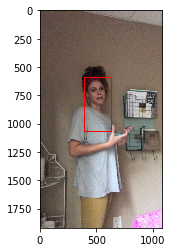

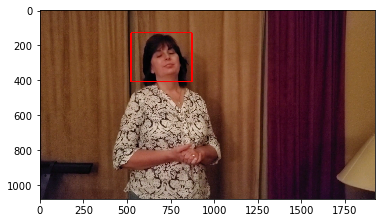

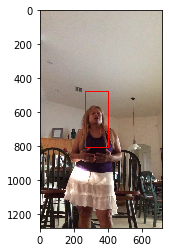

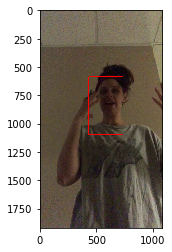

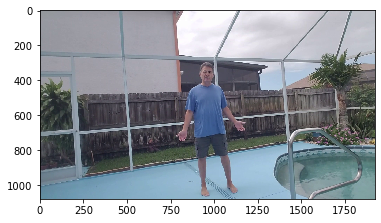

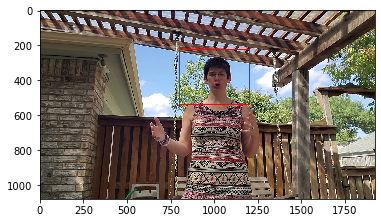

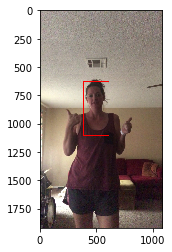

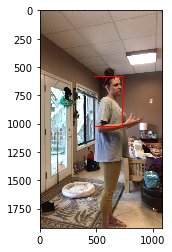

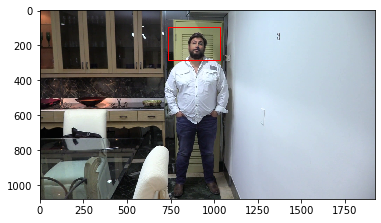

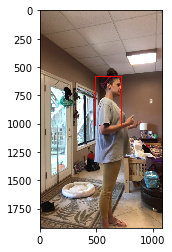

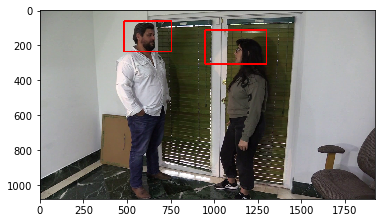

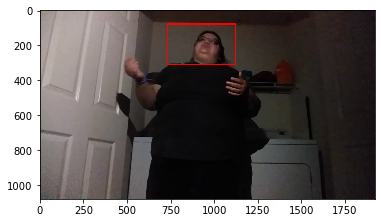

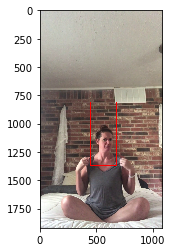

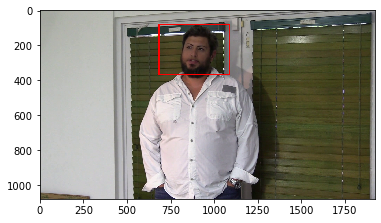

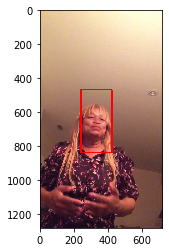

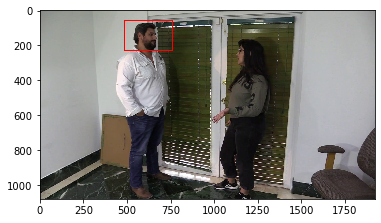

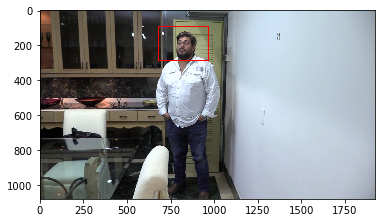

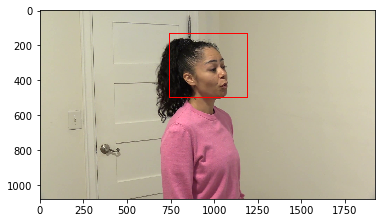

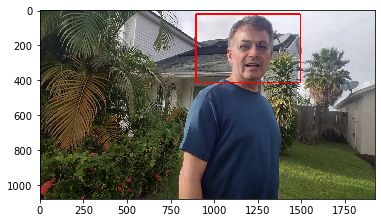

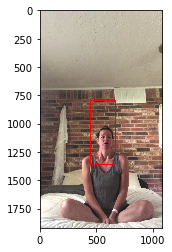

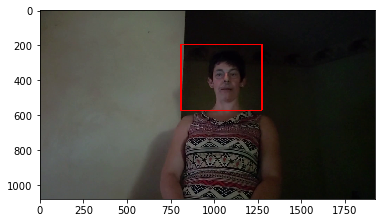

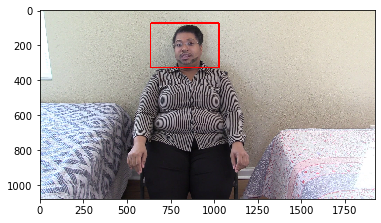

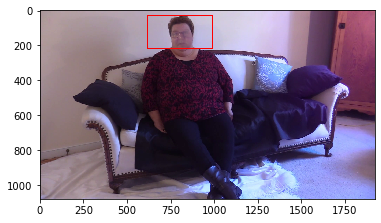

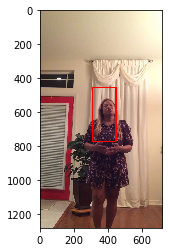

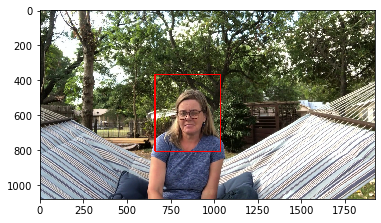

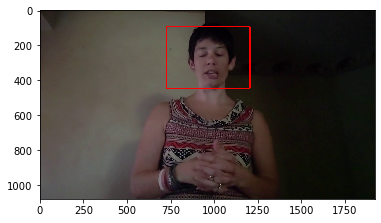

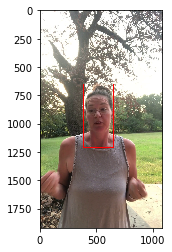

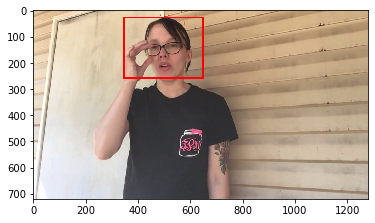

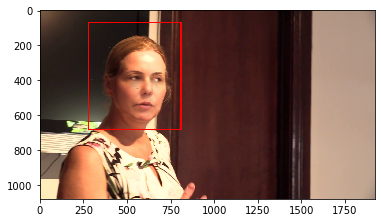

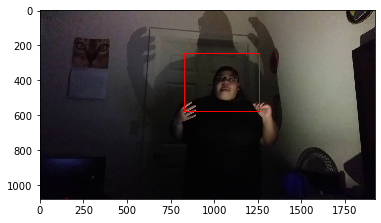

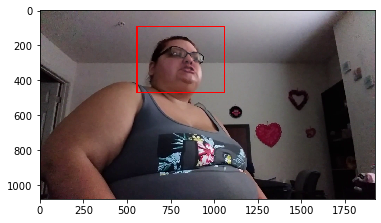

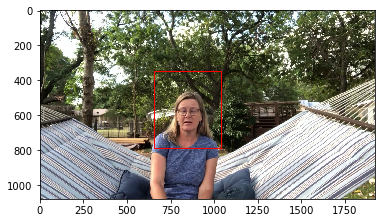

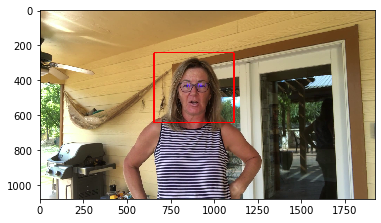

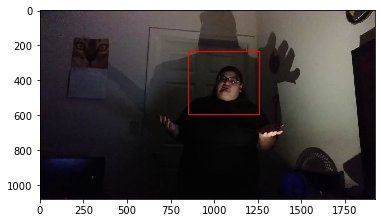

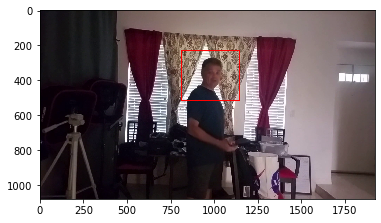

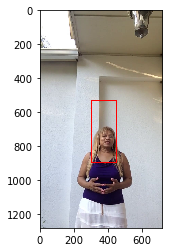

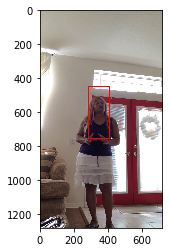

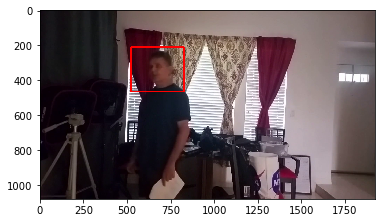

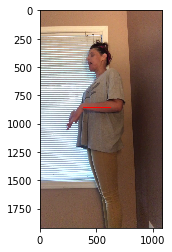

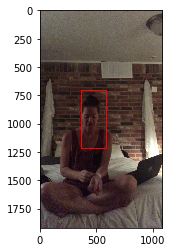

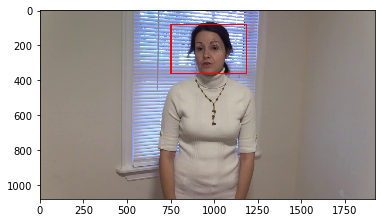

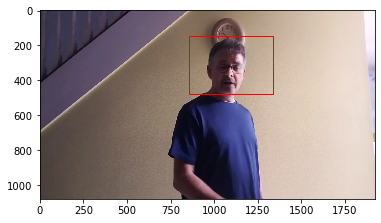

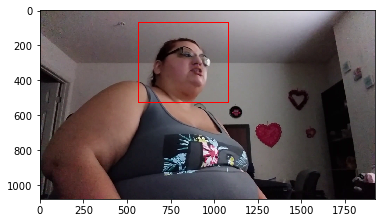

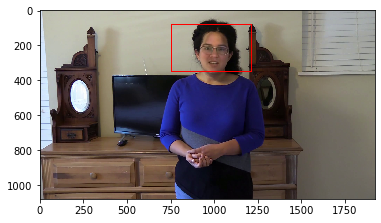

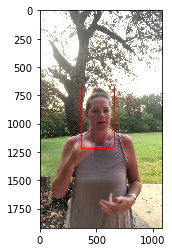

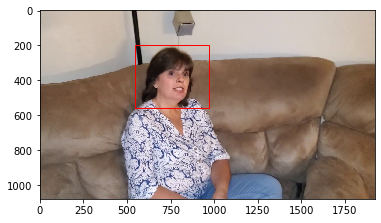

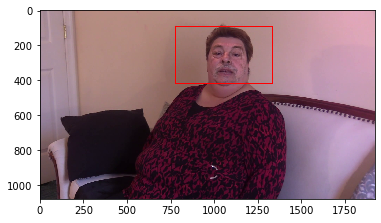

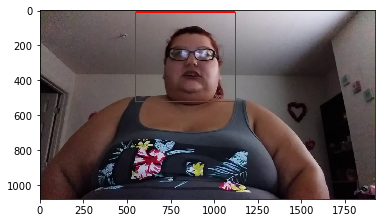

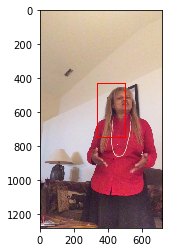

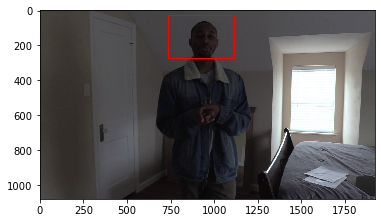

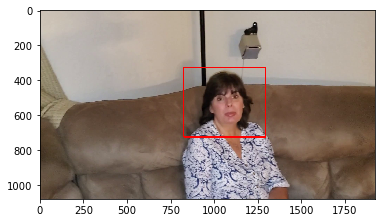

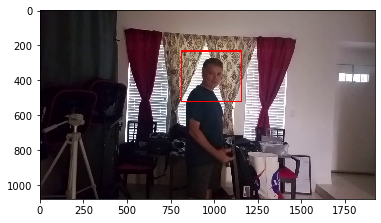

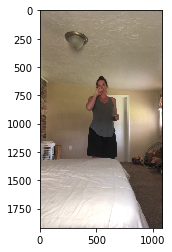

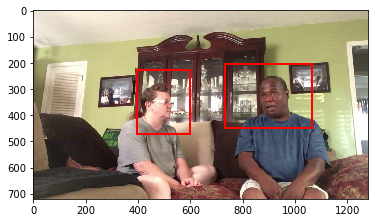

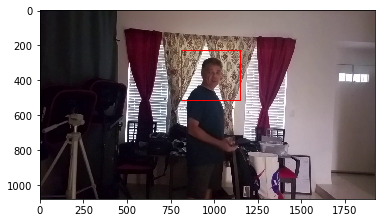

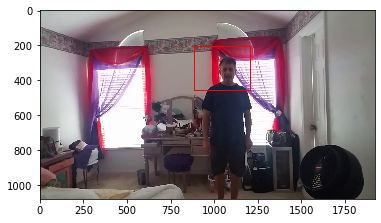

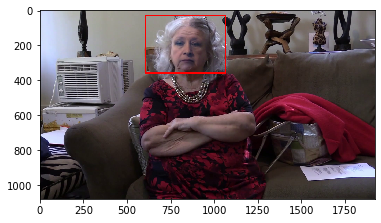

In [193]:
for img in images_with_boxes:
    plt.imshow(img)
    plt.show()

In [208]:
box = boxes_final[0][0]

In [209]:
box

array([118.43567, 811.3553 , 241.94135, 946.77106], dtype=float32)

In [245]:
(int(box[1] - box[3]/8), int(box[0] - box[2]/5)),\
(int(box[3] + box[3]/12), int(box[2] + box[2]/4))

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. dlib.rectangle(left: int, top: int, right: int, bottom: int)
    2. dlib.rectangle(rect: dlib::drectangle)
    3. dlib.rectangle(rect: dlib.rectangle)
    4. dlib.rectangle()

Invoked with: (693, 70), (1025, 302)

In [365]:
r = dlib.rectangle(int(box[1] - box[3]/8), int(box[0] - box[2]/5), int(box[3] + box[3]/12), int(box[2] + box[2]/4))

In [366]:
rs = dlib.rectangles()

In [367]:
rs.append(r)

In [368]:
rs

rectangles[[(693, 70) (1025, 302)]]

In [308]:
image = np.asarray(image_data[0])

In [214]:
face = image[int(box[0] - box[2]/5):int(box[2] + box[2]/4), int(box[1] - box[3]/8):int(box[3] + box[3]/12)]

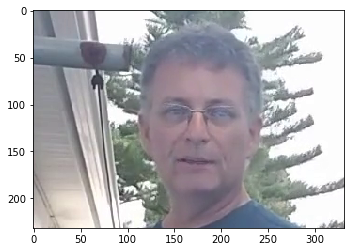

In [215]:
plt.imshow(face)

In [289]:
image = imutils.resize(face, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [228]:
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [378]:
image = np.asarray(image_data[0])
# image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

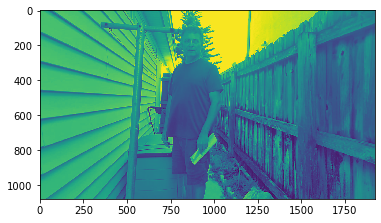

In [343]:
plt.imshow(gray)

In [311]:
detector = dlib.get_frontal_face_detector()

In [344]:
rects = detector(gray, 1)

In [345]:
rects

rectangles[[(820, 152) (927, 259)]]

In [346]:
rects[0]

rectangle(820,152,927,259)

In [369]:
r2 = dlib.rectangle(820,152,1000,259)
rs2 = dlib.rectangles()

In [370]:
rs2.append(r2)

In [371]:
rs2

rectangles[[(820, 152) (1000, 259)]]

In [347]:
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [348]:
rs

rectangles[[(693, 70) (1025, 302)]]

In [372]:
for (i, rect) in enumerate(rs2):
    shape = predictor(image, rect)
    break

In [373]:
shape = face_utils.shape_to_np(shape)

In [374]:
shape

array([[803, 172],
       [800, 188],
       [797, 203],
       [795, 220],
       [801, 234],
       [817, 247],
       [840, 255],
       [867, 259],
       [893, 261],
       [915, 261],
       [933, 256],
       [946, 249],
       [956, 241],
       [963, 231],
       [970, 221],
       [976, 212],
       [980, 202],
       [848, 170],
       [867, 164],
       [889, 163],
       [909, 167],
       [927, 172],
       [952, 175],
       [967, 175],
       [980, 176],
       [992, 179],
       [995, 186],
       [938, 182],
       [938, 188],
       [939, 195],
       [939, 202],
       [906, 211],
       [917, 213],
       [926, 215],
       [934, 216],
       [941, 215],
       [865, 179],
       [879, 177],
       [892, 178],
       [902, 184],
       [889, 184],
       [876, 183],
       [948, 189],
       [961, 186],
       [972, 187],
       [979, 193],
       [971, 194],
       [959, 192],
       [865, 228],
       [888, 227],
       [907, 227],
       [915, 229],
       [923,

In [379]:
for (x, y) in shape:
    cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

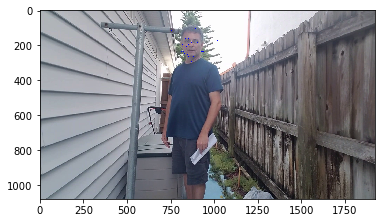

In [376]:
plt.imshow(image)

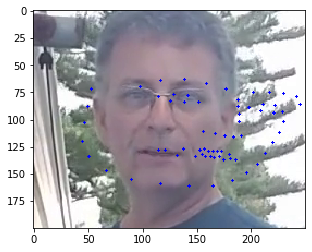

In [380]:
plt.imshow(image[100:300,750:1000])

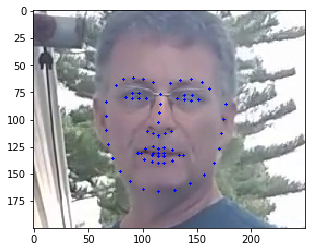

In [340]:
plt.imshow(image[100:300,750:1000])

In [234]:
rects[0]

rectangle(184,116,339,270)

### Legacy / Old stuff

In [203]:
pred

[array([[[[-6.04508281e-01, -2.89438695e-01,  2.09489584e-01, ...,
           -4.49968204e-02, -1.34842920e+01,  1.37683916e+00],
          [-7.97640622e-01, -1.27762973e+00,  3.25729907e-01, ...,
           -1.10311180e-01, -1.40889206e+01,  1.78751540e+00],
          [-2.97825992e-01, -1.27790546e+00,  2.53453135e-01, ...,
           -1.10054821e-01, -1.44891644e+01,  1.83928120e+00],
          ...,
          [-5.64120889e-01, -8.74186099e-01,  1.63710847e-01, ...,
           -5.55234179e-02, -1.46384249e+01,  1.62884068e+00],
          [-2.60692388e-01, -7.89859354e-01,  8.02152753e-02, ...,
           -6.28951713e-02, -1.51082697e+01,  1.71721792e+00],
          [ 3.55615169e-01, -2.73957908e-01, -5.06497145e-01, ...,
           -1.68718733e-02, -1.38724957e+01,  1.46182334e+00]],
 
         [[-4.02831137e-01,  1.87427253e-02,  6.80004805e-02, ...,
           -9.35816765e-02, -1.28531742e+01,  1.57837832e+00],
          [-3.21312398e-01, -3.74267131e-01,  1.79195836e-01, ...,
     

In [170]:
img = video.next_frame()

In [172]:
type(img)

NoneType

In [179]:
imgs[0].shape

(1080, 1920, 3)

In [178]:
len(imgs)

4

In [8]:
classes_path = 'model_data/face_classes.txt'
anchors_path = 'model_data/tiny_yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
input_shape = (416,416) # multiple of 32, hw

In [9]:
model = create_tiny_model(input_shape, anchors, num_classes, freeze_body=2)

Create Tiny YOLOv3 model with 6 anchors and 1 classes.


In [10]:
model.load_weights('tiny-yolov3.h5', by_name=True)

In [215]:
def read_img(path):
    img = Image.open(path)
#     boxed_image = letterbox_image(img, (416,416))
#     image_data = np.array(boxed_image, dtype='float32')
#     image_data /= 255.
    
    return img

In [217]:
image_data = []
img = read_img('../face_detection/znrixntqqb_0.png')
img2 = read_img('../face_detection/aidocisbby_0.png')
img3 = read_img('../face_detection/xpwzoebyho_75.png')
img4 = read_img('../face_detection/xpwzoebyho_75.png')
image_data.append(img)
image_data.append(img2)
image_data.append(img3)
image_data.append(img4)
# image_data = np.array(image_data)
# image_data = np.expand_dims(img, 0) 

In [13]:
pred = model.predict(image_data)
pred

[array([[[[-4.33202267e-01, -3.14866245e-01,  8.05195943e-02, ...,
            1.28650805e-03, -1.34120998e+01,  1.22602880e+00],
          [-6.32266700e-01, -9.82267022e-01,  1.68750972e-01, ...,
           -4.53422554e-02, -1.38912973e+01,  1.52211189e+00],
          [-2.38091663e-01, -8.88163388e-01,  1.90824658e-01, ...,
           -5.72593659e-02, -1.40403919e+01,  1.56430185e+00],
          ...,
          [-3.53867143e-01, -1.18397224e+00,  2.43706778e-01, ...,
           -1.00950450e-01, -1.43914490e+01,  1.80051422e+00],
          [-3.50506961e-01, -1.11416781e+00,  1.14033952e-01, ...,
           -1.06429063e-01, -1.46077042e+01,  1.82597709e+00],
          [-8.33569542e-02, -8.38000238e-01, -5.63848972e-01, ...,
           -4.25685048e-02, -1.38265724e+01,  1.55744076e+00]],
 
         [[-2.28478506e-01, -8.37849602e-02, -1.14372529e-01, ...,
           -8.60875472e-03, -1.28828545e+01,  1.31421685e+00],
          [-1.31293431e-01, -4.32347059e-01,  6.76281229e-02, ...,
     

In [14]:
num_layers = len(anchors)//3
yolo_outputs = pred[:num_layers]
anchor_mask = [[3,4,5], [1,2,3]]

In [152]:
# layer_boxes = []
# layer_boxes = [[] for x in range(num_layers)]
layer_boxes = [[] for x in range(pred[0].shape[0])]
for l in range(num_layers):
    input_shape = K.cast(K.shape(tf.convert_to_tensor(yolo_outputs[l]))[1:3] * 32, \
                         K.dtype(tf.convert_to_tensor(yolo_outputs[l])))
    m = K.shape(yolo_outputs[0])[0] # batch size, tensor
    mf = K.cast(m, K.dtype(tf.convert_to_tensor(yolo_outputs[0])))

    grid, raw_pred, pred_xy, pred_wh = yolo_head(tf.convert_to_tensor(yolo_outputs[l]),
         anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True)
    pred_box = K.concatenate([pred_xy, pred_wh])
    
    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(tf.convert_to_tensor(yolo_outputs[l]),
     anchors[anchor_mask[l]], num_classes, input_shape)

    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, (416, 416))
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    
    cutoff = 0.7
    bpp = len(boxes)/pred[0].shape[0]
    cutoff_boxes = []
    for i in range(pred[0].shape[0]):
        b = boxes.numpy()[int(i*bpp):int((i+1)*bpp)]
        bs = box_scores.numpy()[int(i*bpp):int((i+1)*bpp)]
        if b[np.argwhere(bs>cutoff)[:, 0]].shape[0] > 0:
            layer_boxes[i].extend([b[np.argwhere(bs>cutoff)[:, 0]].tolist(), bs[np.argwhere(bs>cutoff)[:, 0]].flatten().tolist()])
#     break
    # layer_boxes.append(cutoff_boxes)

In [142]:
if b[np.argwhere(bs>cutoff)[:, 0]].shape[0] > 0:

(0, 4)

In [159]:
layer_boxes

[[[[165.03623962402344,
    216.1962127685547,
    182.18804931640625,
    238.88119506835938]],
  [0.9072004556655884]],
 [[[159.50103759765625,
    209.0535430908203,
    177.72056579589844,
    233.44802856445312],
   [160.3238525390625,
    213.9207763671875,
    179.68377685546875,
    241.02853393554688]],
  [0.8007109761238098, 0.9550710320472717]],
 [[[205.37551879882812,
    205.0868377685547,
    221.0983123779297,
    224.9710235595703],
   [204.73268127441406,
    205.90756225585938,
    220.26649475097656,
    225.7814178466797]],
  [0.7365660667419434, 0.9098683595657349]],
 [[[205.37551879882812,
    205.0868377685547,
    221.0983123779297,
    224.9710235595703],
   [204.73268127441406,
    205.90756225585938,
    220.26649475097656,
    225.7814178466797]],
  [0.7365660667419434, 0.9098683595657349]]]

In [158]:
layer_boxes[0]

[[[165.03623962402344,
   216.1962127685547,
   182.18804931640625,
   238.88119506835938]],
 [0.9072004556655884]]

In [157]:
layer_boxes[1][0]

[[159.50103759765625,
  209.0535430908203,
  177.72056579589844,
  233.44802856445312],
 [160.3238525390625,
  213.9207763671875,
  179.68377685546875,
  241.02853393554688]]

In [125]:
b[np.argwhere(bs>cutoff)[:, 0]].tolist()

[[205.37551879882812, 205.0868377685547, 221.0983123779297, 224.9710235595703],
 [204.73268127441406,
  205.90756225585938,
  220.26649475097656,
  225.7814178466797]]

In [104]:
layer_boxes[l][i] = 1

In [105]:
layer_boxes[l][0]

1

In [117]:
layer_boxes

[[[1], [1], [1]], [], [], []]

In [88]:
layer_boxes[l][i]

[]

In [81]:
b[np.argwhere(bs>cutoff)[:, 0]]

array([[205.37552, 205.08684, 221.09831, 224.97102],
       [204.73268, 205.90756, 220.2665 , 225.78142]], dtype=float32)

In [85]:
layer_boxes

[[[[array([], shape=(0, 4), dtype=float32), array([], dtype=float32)]],
  [[array([], shape=(0, 4), dtype=float32), array([], dtype=float32)]],
  [[array([], shape=(0, 4), dtype=float32), array([], dtype=float32)]],
  [[array([], shape=(0, 4), dtype=float32), array([], dtype=float32)]]],
 [[[array([[165.03624, 216.19621, 182.18805, 238.8812 ]], dtype=float32),
    array([0.90720046], dtype=float32)]],
  [[array([[165.03624, 216.19621, 182.18805, 238.8812 ]], dtype=float32),
    array([0.90720046], dtype=float32)]],
  [[array([[165.03624, 216.19621, 182.18805, 238.8812 ]], dtype=float32),
    array([0.90720046], dtype=float32)]],
  [[array([[165.03624, 216.19621, 182.18805, 238.8812 ]], dtype=float32),
    array([0.90720046], dtype=float32)]]]]

In [73]:
[[]]*3

[[], [], []]

In [74]:
[[[]]*pred[0].shape[0] for x in range(num_layers)]

[[[], [], [], []], [[], [], [], []]]

In [ ]:
layer_boxes = [[]* for x in range(num_layers)]

In [68]:
layer_boxes[0][0]

[array([], shape=(0, 4), dtype=float32), array([], dtype=float32)]

In [66]:
layer_boxes

[[[array([], shape=(0, 4), dtype=float32), array([], dtype=float32)],
  [array([], shape=(0, 4), dtype=float32), array([], dtype=float32)],
  [array([], shape=(0, 4), dtype=float32), array([], dtype=float32)],
  [array([], shape=(0, 4), dtype=float32), array([], dtype=float32)]],
 [[array([[165.03624, 216.19621, 182.18805, 238.8812 ]], dtype=float32),
   array([0.90720046], dtype=float32)],
  [array([[159.50104, 209.05354, 177.72057, 233.44803],
          [160.32385, 213.92078, 179.68378, 241.02853]], dtype=float32),
   array([0.800711  , 0.95507103], dtype=float32)],
  [array([[205.37552, 205.08684, 221.09831, 224.97102],
          [204.73268, 205.90756, 220.2665 , 225.78142]], dtype=float32),
   array([0.73656607, 0.90986836], dtype=float32)],
  [array([[205.37552, 205.08684, 221.09831, 224.97102],
          [204.73268, 205.90756, 220.2665 , 225.78142]], dtype=float32),
   array([0.73656607, 0.90986836], dtype=float32)]]]

In [43]:
layer_boxes = [[] for x in range(num_layers)]

In [58]:
layer_boxes[0][0]

[array([], shape=(0, 4), dtype=float32), array([], dtype=float32)]

In [60]:
layer_boxes[1][0].append(layer_boxes[0][0])

In [61]:
layer_boxes[1][0]

[array([[165.03624, 216.19621, 182.18805, 238.8812 ]], dtype=float32),
 array([0.90720046], dtype=float32),
 [array([], shape=(0, 4), dtype=float32), array([], dtype=float32)]]

In [54]:
layer_boxes[0]

[[array([], shape=(0, 4), dtype=float32), array([], dtype=float32)],
 [array([], shape=(0, 4), dtype=float32), array([], dtype=float32)],
 [array([], shape=(0, 4), dtype=float32), array([], dtype=float32)],
 [array([], shape=(0, 4), dtype=float32), array([], dtype=float32)]]

In [17]:
layer_box_scores

[array([[9.4238994e-06],
        [7.3200857e-07],
        [1.1750835e-06],
        ...,
        [6.9621983e-06],
        [1.4765332e-06],
        [3.2261687e-06]], dtype=float32), array([[1.3443485e-05],
        [6.9641992e-06],
        [3.3841907e-06],
        ...,
        [5.7007155e-06],
        [2.7727701e-06],
        [1.2085586e-06]], dtype=float32)]

In [18]:
box_xy, box_wh, box_confidence, box_class_probs = yolo_head(tf.convert_to_tensor(yolo_outputs[l]),
     anchors[anchor_mask[l]], num_classes, input_shape)

boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, (416, 416))
boxes = K.reshape(boxes, [-1, 4])
box_scores = box_confidence * box_class_probs
box_scores = K.reshape(box_scores, [-1, num_classes])

In [19]:
pred[0].shape[0]

4

In [37]:
cutoff = 0.7
bpp = len(boxes)/pred[0].shape[0]
cutoff_boxes = []
for i in range(pred[0].shape[0]):
    b = boxes.numpy()[int(i*bpp):int((i+1)*bpp)]
    bs = box_scores.numpy()[int(i*bpp):int((i+1)*bpp)]
    cutoff_boxes.append([b[np.argwhere(bs>cutoff)[:, 0]], bs[np.argwhere(bs>cutoff)[:, 0]].flatten()])
    print(i)

0
1
2
3


In [38]:
bs[np.argwhere(bs>cutoff)[:, 0]].flatten()

array([0.73656607, 0.90986836], dtype=float32)

In [40]:
len(cutoff_boxes)

4

In [21]:
bs[np.argwhere(bs>cutoff)[:, 0]]

array([[0.73656607],
       [0.90986836]], dtype=float32)

In [22]:
b[np.argwhere(bs>cutoff)[:, 0]]

array([[205.37552, 205.08684, 221.09831, 224.97102],
       [204.73268, 205.90756, 220.2665 , 225.78142]], dtype=float32)

In [23]:
np.sum(np.abs(b[np.argwhere(bs>cutoff)[:, 0]][0] - b[np.argwhere(bs>cutoff)[:, 0]]), axis=1)

array([0.      , 3.105774], dtype=float32)

In [24]:
np.concatenate((bs[np.argwhere(bs>cutoff)[:, 0]],bs[np.argwhere(bs>cutoff)[:, 0]]))

array([[0.73656607],
       [0.90986836],
       [0.73656607],
       [0.90986836]], dtype=float32)

In [25]:
np.concatenate((b[np.argwhere(bs>cutoff)[:, 0]],b[np.argwhere(bs>cutoff)[:, 0]]))

array([[205.37552, 205.08684, 221.09831, 224.97102],
       [204.73268, 205.90756, 220.2665 , 225.78142],
       [205.37552, 205.08684, 221.09831, 224.97102],
       [204.73268, 205.90756, 220.2665 , 225.78142]], dtype=float32)

TypeError: list() takes at most 1 argument (2 given)

In [23]:
int((i+1)*bpp)

8112

In [24]:
boxes.numpy()[int(i*bpp):int((i+1)*bpp)]

array([[  0.8874654,   0.767142 ,  14.0129   ,   9.790259 ],
       [ -7.341978 ,   1.8721727,  21.631058 ,  12.668908 ],
       [ -4.5331726, -15.617149 ,  21.08239  ,  24.762459 ],
       ...,
       [398.72498  , 405.07162  , 417.74442  , 411.45358  ],
       [381.18124  , 404.1366   , 431.003    , 412.4868   ],
       [389.9903   , 389.90283  , 428.95557  , 421.67435  ]],
      dtype=float32)

In [25]:
len(boxes)/pred[0].shape[0]

2028.0

In [26]:
len(boxes)

8112

In [ ]:
cutoff = 0.7
box_scores.numpy()[np.argwhere(box_scores.numpy()>cutoff)[:, :1]]

In [ ]:
boxes.numpy()[np.argwhere(box_scores.numpy()>cutoff)[:, :1]]

In [ ]:
face = boxes.numpy()[np.argwhere(box_scores.numpy()>cutoff)[:, :1]][0][0]

In [170]:
face

array([204.73268, 205.90756, 220.2665 , 225.7814 ], dtype=float32)

In [171]:
# image_with_box = cv2.rectangle(np.asarray(boxed_image), \
#                                (int(face[1]-20), int(face[0]-30)), (int(face[3]+20), int(face[2]+30)), (255, 0, 0), 2) 
# # image_with_box = cv2.rectangle(np.asarray(boxed_image), (216, 165), (238+10, 182+15), (255, 0, 0), 2) 

In [172]:
image_with_box = cv2.rectangle(np.asarray(boxed_image), \
                               (int(face[1]-x_diff), int(face[0]-y_diff)), (int(face[3]+x_diff), int(face[2]+y_diff)), (255, 0, 0), 2) 
# image_with_box = cv2.rectangle(np.asarray(boxed_image), (216, 165), (238+10, 182+15), (255, 0, 0), 2) 

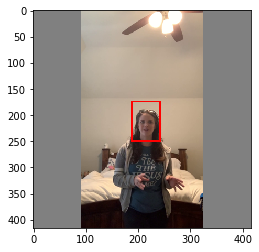

In [173]:
plt.imshow(image_with_box)

In [100]:
x_diff = np.abs(face[3] - face[1])/1.5
y_diff = np.abs(face[2] - face[0])*1.4